In [1]:
import file_path as fp
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import collections
# import os
# from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
input_data = pd.read_csv(fp.csv_folder+"mobile_data_info_train_competition.csv")

for col in input_data.columns.values:
    print(col, ": unique values =", len(input_data[col].unique()), ", non-empty rows =", len(input_data.dropna(subset=[col])))
    
# convert floating points class types to integer. Empty class type is filled with -1
input_data[input_data.columns.values[3:]] = input_data[input_data.columns.values[3:]].fillna(-1.0).astype(int)

itemid : unique values = 160330 , non-empty rows = 160330
title : unique values = 126719 , non-empty rows = 160330
image_path : unique values = 160330 , non-empty rows = 160330
Operating System : unique values = 8 , non-empty rows = 45278
Features : unique values = 8 , non-empty rows = 39345
Network Connections : unique values = 5 , non-empty rows = 23424
Memory RAM : unique values = 11 , non-empty rows = 57037
Brand : unique values = 56 , non-empty rows = 155038
Warranty Period : unique values = 15 , non-empty rows = 48073
Storage Capacity : unique values = 9 , non-empty rows = 63150
Color Family : unique values = 22 , non-empty rows = 84831
Phone Model : unique values = 620 , non-empty rows = 84509
Camera : unique values = 16 , non-empty rows = 24590
Phone Screen Size : unique values = 7 , non-empty rows = 32694


Looks like there are duplicated item titles

In [ ]:
# freq_dict = dict()
# for title in input_data.title.values:
#   if title in freq_dict:
#     freq_dict[title] += 1
#   else:
#     freq_dict[title] = 1
# for k, v in freq_dict.items():
#   if v > 1:
#     print(k)

In [7]:
def is_phone_number(string):
  if len(string) <= 3:
    return False
  digit_count = 0
  for char in string:
    if char.isdigit():
      digit_count += 1
      
  if digit_count > 3:
    return True
  
  return False

In [12]:
vocab_sentence = list()
sentence_id = 0

for line in input_data.title.values:
  tokens = line.split()
  for token in tokens:
    # remove telephone numbers
    if len(token) == 1 and not token.isdigit():
      continue
    if is_phone_number(token):
      continue
      
    vocab_sentence.append((token, sentence_id))
  
  sentence_id += 1

vocabulary, sentence_id_map = list(zip(*vocab_sentence))
  
print('Data size', len(vocabulary))

Data size 1335016


In [16]:
import collections

vocabulary_size = 300

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print("length of the dictionary: ", len(reverse_dictionary), "should be equal to", vocabulary_size)
print("least common words", count[-5:])

Most common words [('samsung', 33200), ('promo', 32830), ('garansi', 31128), ('iphone', 27436), ('1', 25020)]
Sample data [55, 4, 242, 248, 126, 0, 0, 13, 0, 135] ['apple', 'iphone', '4s', 'back', 'glass', 'UNK', 'UNK', 'original', 'UNK', 'putih']
length of the dictionary:  300 should be equal to 300
least common words [('biru', 575), ('carbon', 571), ('international', 567), ('hybrid', 567), ('skin', 564)]


In [20]:
# calculate Term Frequency - Inverse Term Frequency for most common words
known_word_set = set([word for word, _ in count[1:]])

term_freq = dict()
inverse_term_freq = dict()
term_document_count = dict()

for itemid, title in input_data[["itemid", "title"]].values:
  tokens = title.split()
  unique_tokens = set()
  for token in tokens:
    if token not in known_word_set:
      continue
    if (itemid, token) in term_freq:
      term_freq[(itemid, token)] += 1
    else:
      term_freq[(itemid, token)] = 1
    unique_tokens.add(token)
    
  for token in unique_tokens:
    if token in term_document_count:
      term_document_count[token] += 1
    else:
      term_document_count[token] = 1  

n_documents = len(input_data)
for token, count in term_document_count.items():
  inverse_term_freq[token] = math.log(n_documents / count)

# no word is repeated in each title
for k, v in term_freq.items():
  if v > 1:
    print(k)

In [9]:
# data_index = 0
## original method for documentation purpose
# # Step 3: Function to generate a training batch for the skip-gram model.
# def generate_batch(batch_size, num_skips, skip_window):
#   global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
#   batch = np.ndarray(shape=(batch_size), dtype=np.int32)
#   labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
#   span = 2 * skip_window + 1  # [ skip_window target skip_window ]
#   buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
#   if data_index + span > len(data):
#       data_index = 0
#   buffer.extend(data[data_index:data_index + span])
#   data_index += span
#   for i in range(batch_size // num_skips):
#     context_words = [w for w in range(span) if w != skip_window]
#     words_to_use = random.sample(context_words, num_skips)
#     for j, context_word in enumerate(words_to_use):
#       batch[i * num_skips + j] = buffer[skip_window]
#       labels[i * num_skips + j, 0] = buffer[context_word]
#     if data_index == len(data):
#       buffer.extend(data[0:span])
#       data_index = span
#     else:
#       buffer.append(data[data_index])
#       data_index += 1
#   # Backtrack a little bit to avoid skipping words in the end of a batch
#   data_index = (data_index + len(data) - span) % len(data)
#   return batch, labels

# batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
# for i in range(8):
#   print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

4 iphone -> 55 apple
4 iphone -> 242 4s
242 4s -> 248 back
242 4s -> 4 iphone
248 back -> 242 4s
248 back -> 126 glass
126 glass -> 248 back
126 glass -> 0 UNK


In [14]:
data_index = 0
# new
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
      data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      if sentence_id_map[data_index-span+skip_window] == sentence_id_map[data_index-span+context_word]:
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[context_word]
      else:
        batch[i * num_skips + j] = 0
        labels[i * num_skips + j, 0] = 0
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=20, num_skips=2, skip_window=1)
print(input_data.title.head(2).values)
for i in range(20):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

data_index = 0

['apple iphone 4s back glass spare part original replacement putih'
 'iphone 4s 64gb white']
4 iphone -> 55 apple
4 iphone -> 242 4s
242 4s -> 4 iphone
242 4s -> 248 back
248 back -> 126 glass
248 back -> 242 4s
126 glass -> 248 back
126 glass -> 0 UNK
0 UNK -> 126 glass
0 UNK -> 0 UNK
0 UNK -> 13 original
0 UNK -> 0 UNK
13 original -> 0 UNK
13 original -> 0 UNK
0 UNK -> 135 putih
0 UNK -> 13 original
0 UNK -> 0 UNK
135 putih -> 0 UNK
4 iphone -> 242 4s
0 UNK -> 0 UNK


In [17]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 32  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
    )
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
#   saver = tf.train.Saver()

In [18]:
# Step 5: Begin training.
num_steps = min(40000, len(data) * 2 // batch_size) + 1
print("Steps to run:", num_steps)

with tf.Session(graph=graph) as session:
#   Open a writer to write summaries.
#   writer = tf.summary.FileWriter(fp.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
#     writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
#     if step == (num_steps - 1):
#       writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8  # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#         log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
#         print(log_str)
  
  sim = similarity.eval()
  for i in range(valid_size):
    valid_word = reverse_dictionary[valid_examples[i]]
    top_k = 8  # number of nearest neighbors
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
    print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
#   with open(fp.log_dir + '/metadata.tsv', 'w') as f:
#     for i in range(vocabulary_size):
#       f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
#   saver.save(session, os.path.join(fp.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
#   config = projector.ProjectorConfig()
#   embedding_conf = config.embeddings.add()
#   embedding_conf.tensor_name = embeddings.name
#   embedding_conf.metadata_path = os.path.join(fp.log_dir, 'metadata.tsv')
#   projector.visualize_embeddings(writer, config)

# writer.close()

Steps to run: 20860
Initialized
Average loss at step  0 :  96.5740737915039
Average loss at step  2000 :  4.19900248336792
Average loss at step  4000 :  3.4722342113256452
Average loss at step  6000 :  3.415736308813095
Average loss at step  8000 :  3.4056943479776383
Average loss at step  10000 :  3.3784069432020187
Average loss at step  12000 :  3.369918919324875
Average loss at step  14000 :  3.3631584458351136
Average loss at step  16000 :  3.3553554317951204
Average loss at step  18000 :  3.3519742780923845
Average loss at step  20000 :  3.3466137223243715
Nearest to samsung: advan, galaxy, core, lenovo, asus, sony, platinum, carbon
Nearest to xperia: z3, dual, on, bluetooth, andromax, back, 1gb, j1
Nearest to wa: whatsapp, termurah, order, kami, jual, mito, ramadhan, biru
Nearest to pro: prime, mix, a37, warna, a2, mini, platinum, core
Nearest to plus: midnight, v7, f1, 9, phone, white, space, kamera
Nearest to ori: original, like, asli, segel, bekas, mulus, no, grey
Nearest to m

In [11]:
# Step 6: Visualize the embeddings.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = min(500, vocabulary_size)
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  return plt

[]

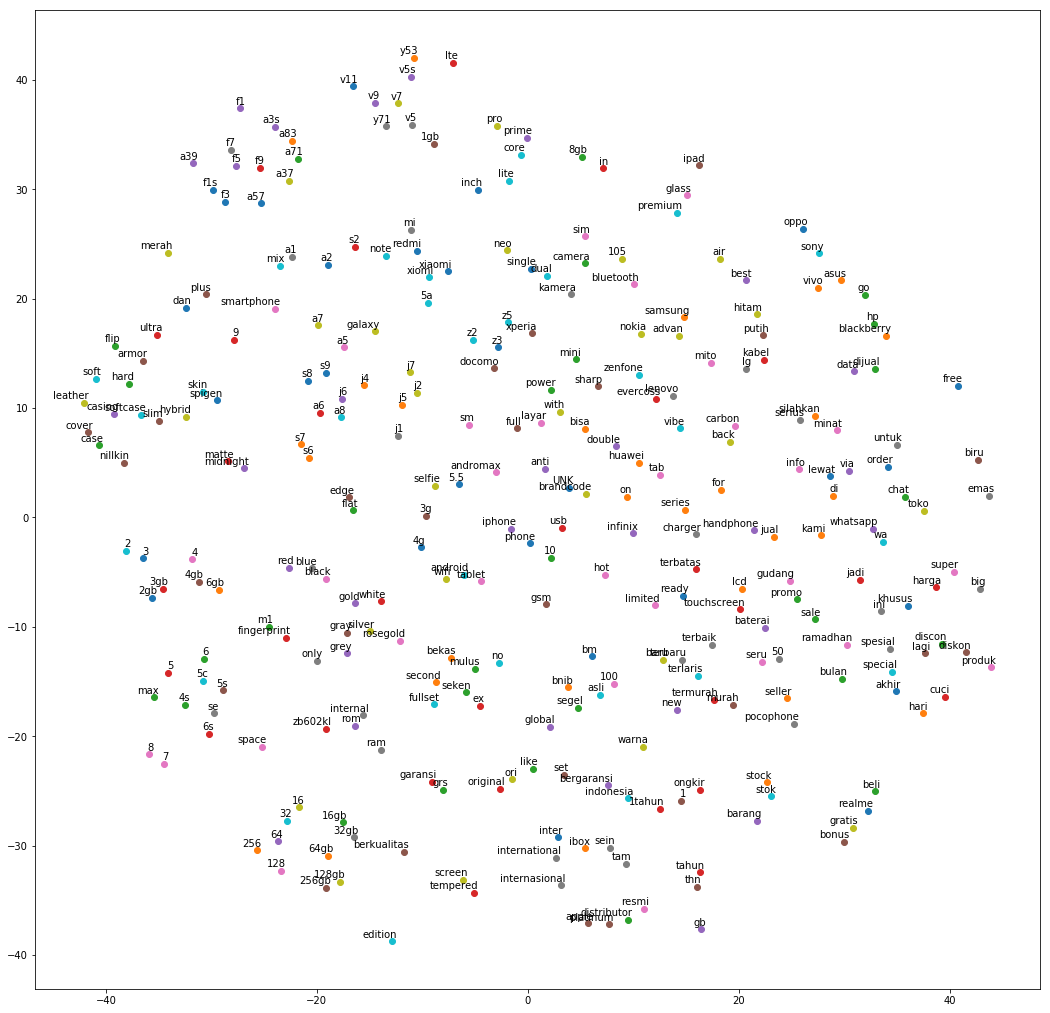

In [12]:
plot_with_labels(low_dim_embs, labels).plot()

Let's try to calculate the feature vector for each title using the the TF-IDF weighted word vector of known words

In [21]:
def get_avg_title_vector(itemid, title, use_tf_idf):
  tokens = title.split()
  total_score = 0.0
  total_vec = np.zeros(embedding_size)
  for token in tokens:
    if token not in known_word_set:
      continue
    word_vec = final_embeddings[dictionary[token]]
    if use_tf_idf:
      tf_idf_score = term_freq[(itemid, token)] * inverse_term_freq[token]
    else:
      tf_idf_score = 1.0
    total_score += tf_idf_score
    total_vec += word_vec * tf_idf_score
  
  if total_score == 0.0:
    return None
  return total_vec / total_score

input_data["title_vector"] = input_data.apply(lambda x: get_avg_title_vector(x.itemid, x.title, False), axis=1)

from sklearn.model_selection import train_test_split
train, test = train_test_split(input_data.dropna(subset=["title_vector"]), test_size=0.2, random_state=12345)

In [22]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(X, true_y):
  labels = input_data[y_col].unique()
  labels.sort()
  
  print(clf)
  print("Vector size", embedding_size, "; Vocab size", vocabulary_size,
        "; Num skips", num_skips, "; Skip window", skip_window)
  print(labels)
  print(confusion_matrix(true_y, clf.predict(X), labels=labels))

In [23]:
# undersample empty labels

y_col = "Operating System"

reduction_factor = 3

valid_train = train[train[y_col] != -1]
empty_train = train[train[y_col] == -1]
sampled_empty_train = empty_train.sample(n=min(len(empty_train), len(valid_train)//reduction_factor), random_state=0)

new_train = pd.concat([valid_train, sampled_empty_train])

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(np.stack(new_train.title_vector.values), new_train[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import confusion_matrix

labels = mobile_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(np.stack(test.title_vector.values)),
                 labels=labels))

[-1  0  1  2  3  4  5  6]
[[21764     7    74    10    22     0     2   997]
 [   22    10     0     0     0     0     0     0]
 [  977     0   136     0     1     0     1    13]
 [   49     0     0     3     0     0     0     1]
 [  226     0     0     1    44     0     0    17]
 [    0     0     0     0     0     0     0     0]
 [    8     0     0     0     0     0     2     0]
 [ 5484     0     2     0     2     0     0  1968]]


use TF-IDF score to normalize impact of common words still appears to have better performance

In [121]:
from sklearn.metrics import confusion_matrix

labels = mobile_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(np.stack(test.title_vector.values)),
                 labels=labels))

[-1  0  1  2  3  4  5  6]
[[21740     1    61     4    18     0     0  1025]
 [   24     8     0     0     0     0     0     0]
 [  967     0   151     0     0     0     0    10]
 [   49     0     0     4     0     0     0     2]
 [  240     0     0     0    57     0     0    15]
 [    1     0     0     0     0     0     0     0]
 [    4     0     0     0     0     0     0     0]
 [ 5379     0     7     1     4     0     0  2071]]


In [17]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# with tf-idf score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[ 6295    12  2173    49    72     1     9 14104]
 [   11    14     0     0     0     0     0    10]
 [  190     0   662     0     0     0     0   251]
 [   23     2     0    21     0     0     0    14]
 [   24     1     2     1    64     0     0   224]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     5]
 [  337     1    54     1    12     0     0  7203]]


In [25]:
print_confusion_matrix(np.stack(test.title_vector.values), test[y_col].values)
# disabled tf-idf score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Vector size 32 ; Vocab size 300 ; Num skips 2 ; Skip window 1
[-1  0  1  2  3  4  5  6]
[[ 5948    12  2502    49    61     1     9 14133]
 [   12    13     0     0     0     0     0    10]
 [  163     0   748     0     0     0     0   192]
 [   23     2     0    21     0     0     0    14]
 [   24     1     1     2    57     0     0   231]
 [    0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     5]
 [  313     1    64     1    12     0     0  7217]]


In [34]:
temp = test[["title", "Operating System"]]
temp["predicted_os"] = clf.predict(np.stack(test.title_vector.values))
temp[(temp["Operating System"] == 1) & (temp["predicted_os"] == 6)]

C:\Users\chenz\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,Operating System,predicted_os
145156,vivo y71 2 16gb garansi resmi barang original ...,1,6
71356,sony experia z3 green class lte tanpa kendala ...,1,6
101041,diskon 50 jual iphone 5s silver 32 gb promo cu...,1,6
115310,hot big sale promo terlaris google pixel ram 4...,1,6
2303,big promo ahkir tahun samsung j1 ace 2016,1,6
116138,minat serius chat wa 0878 4390 2333 iphone 6 3...,1,6
149419,big promo diskon super 90 off hp sale ready ip...,1,6
20235,termurah apple iphone 5 16gb bisa semua sim ca...,1,6
22219,big promo ahkir tahun samsung galaxy note 8 ma...,1,6
57651,beli 2 gratis 1 iphone5s silahkan chat via wa ...,1,6


In [29]:
temp[temp["Operating System"]==3]

,title,Operating System,predicted_os
114172,promo lenovo ideapad 320 14isk 80xg00 1fid cor...,3,6
17033,sony harddisk hdd 1tb usb 3.0 hd sl1 black,3,-1
98943,promo asus a442ur ga041t dark gray core i5 825...,3,6
68484,xiaomi mi notebook pro i5 8gb 256gb 15.6inch w...,3,6
82439,promo akhir thn toshiba l840 white core i5 321...,3,6
155657,big promo toko sukmasek hp.iphone handphone hp...,3,6
19241,ready advan vanbook w100 windows original,3,6
120477,huawei matebook x wt w19 13 inch windows 10 os...,3,6
155792,asus transformer ready stock beli 2 gratis 1,3,3
74031,wacom one medium ctl 672 pen tablet berkualita...,3,3


In [18]:
clf.feature_importances_

array([0.02680677, 0.03015921, 0.03269704, 0.03979252, 0.02432418,
       0.02811599, 0.02514731, 0.02622634, 0.02675659, 0.02994319,
       0.02833968, 0.02629829, 0.02771391, 0.04967194, 0.02627824,
       0.04263372, 0.03602246, 0.03048933, 0.02823685, 0.02525861,
       0.02882704, 0.03355459, 0.0551984 , 0.02712904, 0.02597874,
       0.02508587, 0.02808761, 0.02572205, 0.02529292, 0.04525914,
       0.0415397 , 0.02741273])

In [1]:
import pretrained_resnet
from keras.optimizers import SGD
import cv2
import numpy as np
from keras.models import Model

Using TensorFlow backend.


In [26]:
model = pretrained_resnet.resnet152_model(fp.image_base_folder+"resnet152_weights_tf.h5")
resnet_features = Model(inputs=model.input, outputs=model.layers[-2].output)

ValueError: No such layer: flatten_5

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

In [9]:
im = cv2.resize(cv2.imread('D:/NDSC_2019/images/mobile_image/3b9a11608551b11b9330268e0d055e01.jpg'), (224, 224)).astype(np.float32)

# Remove train image mean
im[:,:,0] -= np.average(im[:,:,0])
im[:,:,1] -= np.average(im[:,:,1])
im[:,:,2] -= np.average(im[:,:,2])
# Insert a new dimension for the batch_size
im = np.expand_dims(im, axis=0)

In [22]:



preds = intermediate_layer_model.predict(im)
preds.shape

(1, 2048)

In [23]:
preds

array([[0.43904227, 0.00513907, 0.4066957 , ..., 4.052741  , 0.        ,
        0.        ]], dtype=float32)